<font color='blue' size=5><b>Комментарий ревьюера</b></font>

<font color='blue'>Привет! Меня зовут Павел Григорьев, и я буду проверять этот проект.<br>Моя основная цель - не указать на совершённые тобой ошибки, а поделиться своим опытом и помочь тебе совершенствоваться как профессионалу.<br>Спасибо за проделанную работу! Предлагаю общаться на «ты».</font>
<details>
	<summary><u>Инструкция по организационным мометнам (кликабельно)</u></summary>
<font color='blue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font>


---


<font color='blue'>синий текст - просто текст комментария</font>

<font color='green'>✔️ и зеленый текст - все отлично</font>

<font color='orange'>⚠️ и оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</font>

<font color='red'>❌ и красный текст - есть недочеты</font>


</details>    
    </br>
<font color='blue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное. </font>

Ответы на мои комментарии лучше тоже помечать.
Например: <font color='purple'><b>Комментарий студента</b></font>

<font color='blue'><b>Давай смотреть, что получилось!</b></font>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
    
Привет! 

Спасибо за ревью и указение на недочеты, теперь всё встало на свои места.

</div>

<font color='blue' size=3><b>Комментарий ревьюера 2</b></font>

<font color='blue'>Привет еще раз. Спасибо, за исправления. Оформление комментариев по работе сохраняется. Только обозначим, что это вторая итерация.</font>

# Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

В колонках датасета содержатся следующие данные:
- longitude — широта;
- latitude — долгота;
- housing_median_age — медианный возраст жителей жилого массива;
- total_rooms — общее количество комнат в домах жилого массива;
- total_bedrooms — общее количество спален в домах жилого массива;
- population — количество человек, которые проживают в жилом массиве;
- households — количество домовладений в жилом массиве;
- median_income — медианный доход жителей жилого массива;
- median_house_value — медианная стоимость дома в жилом массиве;
- ocean_proximity — близость к океану.

**Цель данной работы** - Построить модель линейной регрессии, способную предсказать медианную стоимость дома в жилом массиве.

**Работа пройдет в следующие 5 этапов:**
1. Загрузка библиотек и инциализация функция и Spark-сессии;
2. Подготовка и анализ данных;
3. Обучение моделей;
4. Анализ результатов;
5. Завершение Spark-сессии;
6. Вывод

## Библиотеки, функции и Spark-сессия

### Библиотеки

In [1]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F

from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler

pyspark_version = pyspark.__version__
if int(pyspark_version[:1]) == 3:
    from pyspark.ml.feature import OneHotEncoder    
elif int(pyspark_version[:1]) == 2:
    from pyspark.ml.feature import OneHotEncodeEstimator

from pyspark.ml.stat import Correlation

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit

from pyspark.mllib.recommendation import ALS, Rating
from pyspark.mllib.evaluation import RegressionMetrics

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 42
TEST_SIZE = [.75,.25]

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

### Функции

In [2]:
def create_visualization(data, dtype, target, figsize=(12, 5), bins=50, target_type='classification'):
    if dtype == 'quantitative':
        print('Visualization of quantitative features distribution:')
        print()
        
        for i in data.drop(target, axis=1):
            if data[i].dtype != 'O' and list(data[i].unique()) != [0, 1]:
                print('-----------------------------------------------------------------------------------------------')
                print(f'Feature: {i}')

                figure, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},
                                                         figsize=figsize)

                sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

                sns.boxplot(data[i], ax=ax_box).set_title(i, y=1.5, fontsize=14)
                sns.histplot(data[i], bins=bins, kde=True, ax=ax_hist)

                plt.show()
                print()
                print('Feature statistics:')
                display(pd.DataFrame(data[i].describe()))
    elif dtype == 'category':
        print('Visualization of categorical features and target prevalence:')
        print()

        for i in data.drop(target, axis=1):
            if data[i].dtype == 'O' or list(data[i].unique()) == [0, 1]:
                bar_data = data[i].value_counts().reset_index().rename(
                    columns={'index': data[i].name, data[i].name: 'Count'}).sort_values(by=i)
                prev_data = data.pivot_table(index=i, values=target).reset_index().sort_values(by=i)

                print('-----------------------------------------------------------------------------------------------')
                print(f'Feature: {i}')

                figure, (ax_bar, ax_prev) = plt.subplots(1, 2, figsize=figsize)

                sns.barplot(
                    data=bar_data,
                    x=bar_data[data[i].name], y=bar_data['Count'],
                    ax=ax_bar
                ).set_title(i, y=1.02, fontsize=14)
                sns.barplot(
                    data=prev_data,
                    x=prev_data[i], y=prev_data[target],
                    ax=ax_prev
                ).set_title(f'{i}. Target prevalence', y=1.02, fontsize=14)

                plt.show()
                # print()
                # print('Feature statistics:')
                # display(pd.DataFrame(data[i].describe()))
    elif dtype == 'target':
        print('Visualization of target distribution:')
        print()
        print(f'Target: {target}')
        
        if target_type == 'classification':
            plt.figure(figsize=(7, 5))
            
            sns.barplot(
                data=data[target].value_counts().reset_index().rename(
                    columns={'index': data[target].name, data[target].name: 'Count'}),
                x=data[target], y='Count'
            ).set_title(target, y=1.02, fontsize=14)
        elif target_type == 'regression':
            figure, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={"height_ratios": (.15, .85)},
                                                     figsize=figsize)

            sns.despine(fig=None, ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

            sns.boxplot(data[target], ax=ax_box).set_title(target, y=1.5, fontsize=14)
            sns.histplot(data[target], bins=bins, kde=True, ax=ax_hist)

        plt.show()
        print()
        print('Target statistics:')
        display(pd.DataFrame(data[target].describe()))
        
        
def get_corr_map(df, method='pearson', figisze=(15, 12)):
    vector_col = 'corr_features'
    assembler = VectorAssembler(inputCols=df.columns, outputCol=vector_col)
    vect = VectorAssembler(inputCols=df.columns,
                           outputCol=vector_col) \
                           .transform(data) \
                           .select(vector_col)
    
    df = pd.DataFrame(Correlation.corr(vect, vector_col, method=method).collect()[0][0].toArray(),
                      columns=df.columns)
    
    plt.figure(figsize=figisze)

    sns.heatmap(
        round(df.corr(method=method), 2), vmax=1, vmin=-1, square=True, linewidths=3, annot=True, cmap='coolwarm'
    )

    plt.show()

### Инициализация Spark-сессии

In [3]:
spark = SparkSession.builder \
                    .master('local') \
                    .appName('EDA California Housing') \
                    .getOrCreate()

print('Spark session has been initialized')

Spark session has been initialized


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>👍</font>

## Подготовка и анализ данных

Для достижения поставленной цели нам необходимо загрузить данные и сформировать из них датасет, определив параметры `features` и целевой признак `target`.

Для это последовательно выполним следующие шаги:
1. Загрузим данные и проведем их верхнеуровневый анализ;
2. Проведем предобработку данных и создадим дополнительные независимые признаки;
3. Сформируем два датесета - с колличественными признаки и с колличесвенными и категориальными признаками;
4. Сформируем обучюащие и валидационные выборки.


Разобъем оба датасета на обучающие и валидационные выборки в соотношении 80% к 20%.

После формирования обучающей выборки, для избежания утечек данных, обработаем выборки следующим образом:
- OHE для категориального признака;
- StandardScaler для колличественных признаков.

### Загрузка и верхнеуровневый анализ данных

In [4]:
data = spark.read.load('/datasets/housing.csv', format='csv', inferSchema=True, header=True)

print('Raw data:')
print()
data.show(5)

Raw data:

+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|longitude|latitude|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|median_house_value|ocean_proximity|
+---------+--------+------------------+-----------+--------------+----------+----------+-------------+------------------+---------------+
|  -122.23|   37.88|              41.0|      880.0|         129.0|     322.0|     126.0|       8.3252|          452600.0|       NEAR BAY|
|  -122.22|   37.86|              21.0|     7099.0|        1106.0|    2401.0|    1138.0|       8.3014|          358500.0|       NEAR BAY|
|  -122.24|   37.85|              52.0|     1467.0|         190.0|     496.0|     177.0|       7.2574|          352100.0|       NEAR BAY|
|  -122.25|   37.85|              52.0|     1274.0|         235.0|     558.0|     219.0|       5.6431|          341300.0|       NEAR BAY|
|  -122.25|   37.85|   

In [5]:
print('Data types:')

pd.DataFrame(data.dtypes, columns=['column', 'type'])

Data types:


,column,type
0,longitude,double
1,latitude,double
2,housing_median_age,double
3,total_rooms,double
4,total_bedrooms,double
5,population,double
6,households,double
7,median_income,double
8,median_house_value,double
9,ocean_proximity,string


In [6]:
print('Data statistics:')

data.describe().toPandas().set_index('summary').T

Data statistics:


summary,count,mean,stddev,min,max
longitude,20640,-119.56970445736148,2.003531723502584,-124.35,-114.31
latitude,20640,35.6318614341087,2.135952397457101,32.54,41.95
housing_median_age,20640,28.639486434108527,12.58555761211163,1.0,52.0
total_rooms,20640,2635.7630813953488,2181.6152515827944,2.0,39320.0
total_bedrooms,20433,537.8705525375618,421.38507007403115,1.0,6445.0
population,20640,1425.4767441860465,1132.46212176534,3.0,35682.0
households,20640,499.5396802325581,382.3297528316098,1.0,6082.0
median_income,20640,3.8706710029070246,1.899821717945263,0.4999,15.0001
median_house_value,20640,206855.81690891474,115395.61587441359,14999.0,500001.0
ocean_proximity,20640,None,None,<1H OCEAN,NEAR OCEAN


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Отлично!  Выведены типы данных, статистика и первые строчки датафрейма. </font>

### Предобработка данных и feature engineering

#### Обработка пропусков в данных

In [7]:
print('Missing values in data:')
print()
for column in data.columns:
    print(column, data.filter(data[column].isNull()).count())

Missing values in data:

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


В поле `total_bedrooms` присутствует 207 пропусков.

Поскольку в данном поле отсутствуют нулевые значения, можно предположить, что пропуски обозначают отсутствие ванн, поэтому заполним пропуски значением 0.

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Пропуски заполнены!</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>Находим медиану.:</font>
`int(df_housing.approxQuantile('total_bedrooms', [0.5], 0)[0])`

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
Спасибо за подсказку данного метода. Хотел уточнить почему ты релкомендуешь заполнять именно медианой?
    
В данных минимальное значение - 1, исходя из колличества пропусков я предположил, что пропуск означает отсутствие ванны, поэтому и заполнил пропуски 0.
</div>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ⚠️\
<font color='darkorange'> Хочется верить, что в Калифорнии нет жилых массивов с количеством спален = 0 )).\
Ну и я знаю этот датасет в его начальной форме )). [California housing dataset](https://developers.google.com/machine-learning/crash-course/california-housing-data-description)</font>

In [8]:
data = data.na.fill(0)

print('Checking for missing values in data:')
print()
for column in data.columns:
    print(column, data.filter(data[column].isNull()).count())

Checking for missing values in data:

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


#### Обработка дубликатов в данных

In [9]:
duplicates = data.count() - data.drop_duplicates().count()

if duplicates > 0:
    data = data.drop_duplicates()
    print(f'{duplicates} duplicates have been removed')

print('Duplicates in data:', duplicates)

Duplicates in data: 0


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>👍</font>

#### Feature engineering

Создадим следующие дополнительные независимые признаки:
- `rooms_per_household` - отношение количества комнат к количеству домовладений;
- `population_in_household` - отношение количества проживающих в массиве людей к количеству домовладений;
- `bedroom_index` - отношение количества спален к количеству комнат.

In [10]:
data = data.withColumn('rooms_per_household', F.col('total_rooms') / F.col('households'))
data = data.withColumn('population_in_household', F.col('population') / F.col('households'))
data = data.withColumn('bedroom_index', F.col('total_bedrooms') / F.col('total_rooms'))

print('Data schema:')
data.printSchema()

Data schema:
root
 |-- longitude: double (nullable = false)
 |-- latitude: double (nullable = false)
 |-- housing_median_age: double (nullable = false)
 |-- total_rooms: double (nullable = false)
 |-- total_bedrooms: double (nullable = false)
 |-- population: double (nullable = false)
 |-- households: double (nullable = false)
 |-- median_income: double (nullable = false)
 |-- median_house_value: double (nullable = false)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



### Исследовательский анализ данных

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
    
Привет! 

Подскажи как быть с исследовательским анализом данных, используя spark?

Не нашел способа строить графики, за исключением перевода в пандас (.toPandas()) или использовании модуля Pandas API (https://spark.apache.org/docs/latest/api/python/getting_started/quickstart_ps.html), который почему-то недоступен в jupyterHub.

Однако почитав внимательнее про to.Pandas () можно увидеть, что такой метод реализуется силами драйвера, что при большом объеме данных может положить его.

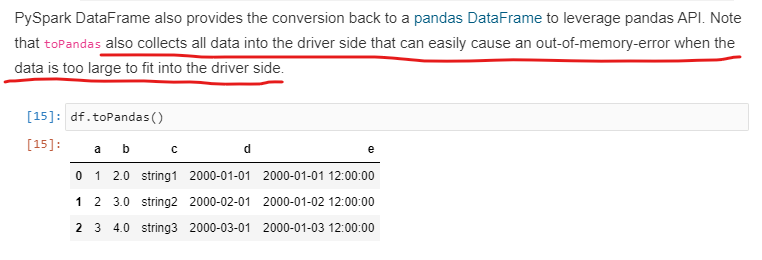

Поэтому вопрос: как же мне сделать анализ, чтобы все вычисления проводили исполнители?)

Была идея написать функцию, которая будет бинить распределения, а затем эти бины уже переводить в пандас и строить график по этим бинам, но из-за сроков не успеваю это сделать. Надеюсь, что есть более простой способ)

Буду очень благодарен, если подскажешь его! Спасибо!

</div>

<font color='blue'><b>Комментарий ревьюера: </b></font>\
<font color='blue'>Верно, если данные действительно большие то, это может привести к переполнению памяти.\
Можно агрегировать данные для визуализации с помощью методов Spark и выгружать уже собранные данные.\
Можено выгружать по столбцам. Чаще всего при больших данных используют сэмплирование (df.sample(True, 0.001, seed=RS)).\
Выбор зависит от данных )).</font>

#### Анализ колличественных признаков

Visualization of quantitative features distribution:

-----------------------------------------------------------------------------------------------
Feature: longitude


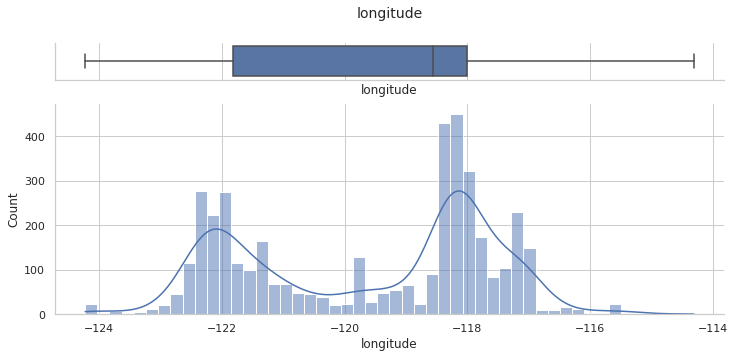


Feature statistics:


,longitude
count,4169.000000
mean,-119.600573
std,2.015258
min,-124.230000
25%,-121.820000
50%,-118.560000
75%,-118.010000
max,-114.310000


-----------------------------------------------------------------------------------------------
Feature: latitude


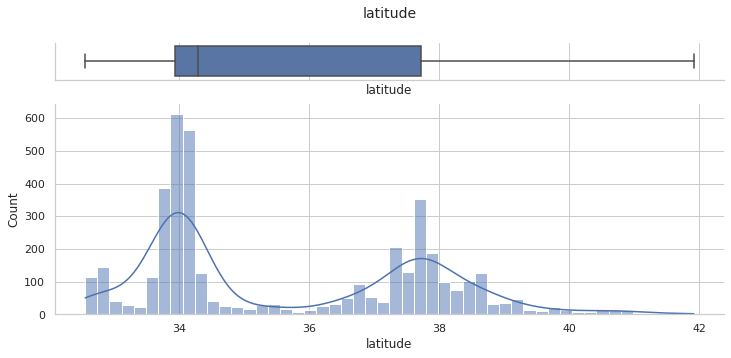


Feature statistics:


,latitude
count,4169.000000
mean,35.668213
std,2.135830
min,32.560000
25%,33.940000
50%,34.290000
75%,37.730000
max,41.920000


-----------------------------------------------------------------------------------------------
Feature: housing_median_age


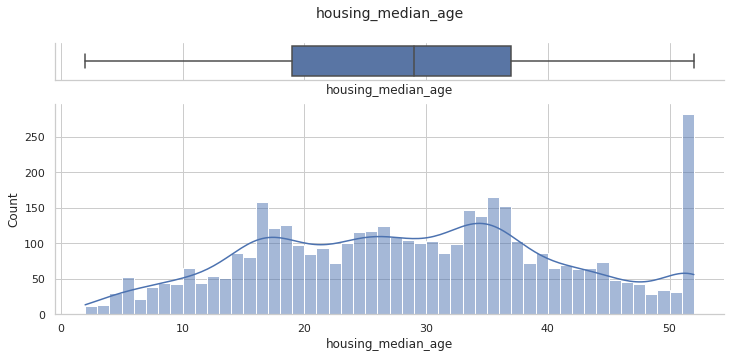


Feature statistics:


,housing_median_age
count,4169.000000
mean,28.791317
std,12.539022
min,2.000000
25%,19.000000
50%,29.000000
75%,37.000000
max,52.000000


-----------------------------------------------------------------------------------------------
Feature: total_rooms


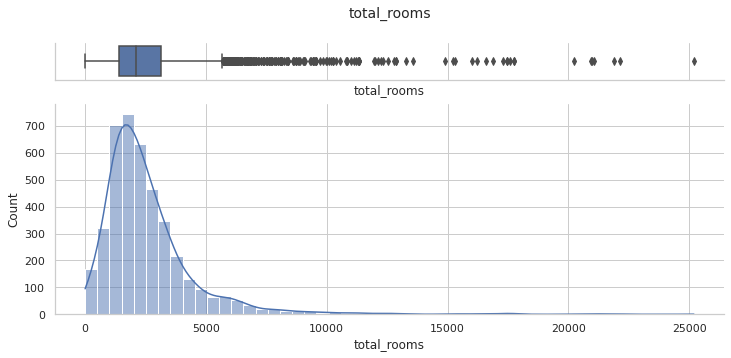


Feature statistics:


,total_rooms
count,4169.000000
mean,2601.991845
std,2050.639132
min,16.000000
25%,1436.000000
50%,2131.000000
75%,3146.000000
max,25187.000000


-----------------------------------------------------------------------------------------------
Feature: total_bedrooms


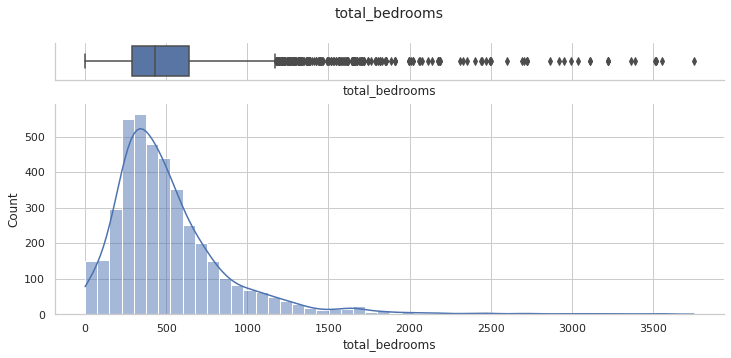


Feature statistics:


,total_bedrooms
count,4169.000000
mean,523.901655
std,395.537338
min,0.000000
25%,288.000000
50%,431.000000
75%,642.000000
max,3753.000000


-----------------------------------------------------------------------------------------------
Feature: population


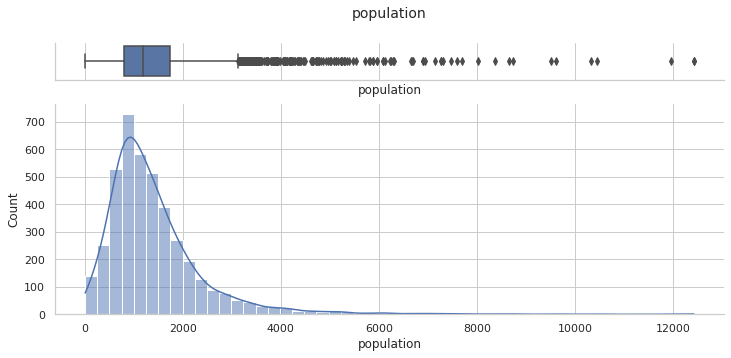


Feature statistics:


,population
count,4169.000000
mean,1415.715279
std,1052.112241
min,5.000000
25%,791.000000
50%,1179.000000
75%,1728.000000
max,12427.000000


-----------------------------------------------------------------------------------------------
Feature: households


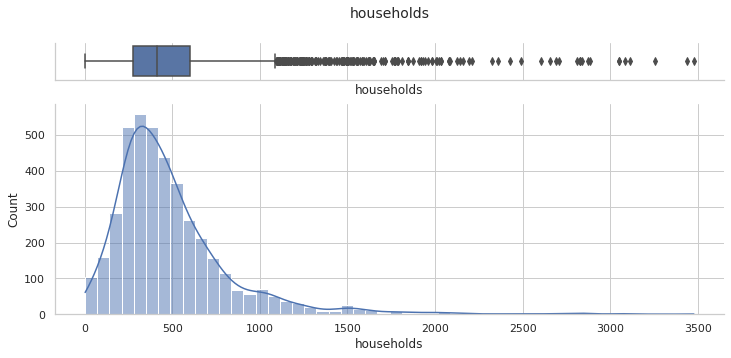


Feature statistics:


,households
count,4169.000000
mean,494.068362
std,358.958859
min,2.000000
25%,277.000000
50%,410.000000
75%,602.000000
max,3478.000000


-----------------------------------------------------------------------------------------------
Feature: median_income


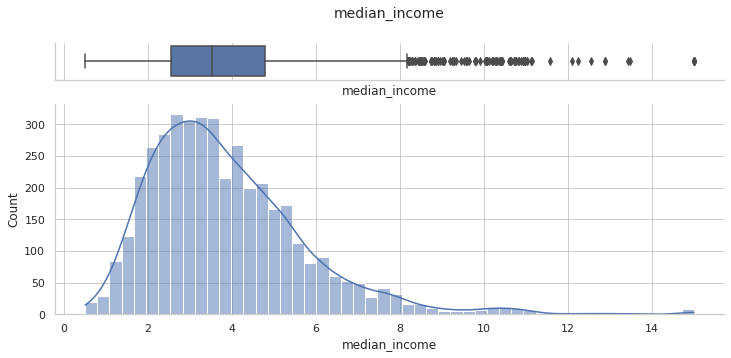


Feature statistics:


,median_income
count,4169.000000
mean,3.865959
std,1.883773
min,0.499900
25%,2.543700
50%,3.532600
75%,4.795200
max,15.000100


-----------------------------------------------------------------------------------------------
Feature: rooms_per_household


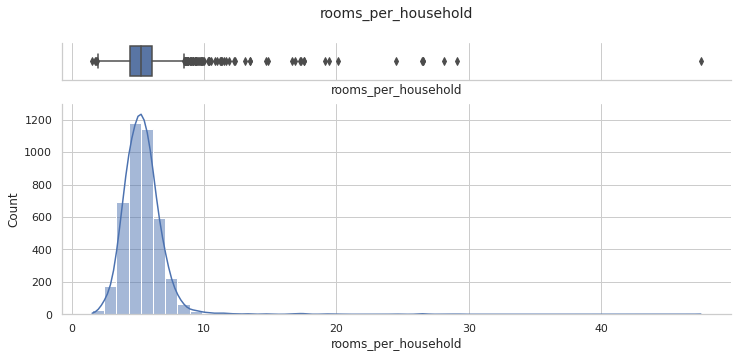


Feature statistics:


,rooms_per_household
count,4169.000000
mean,5.381003
std,1.775687
min,1.553030
25%,4.433962
50%,5.235714
75%,6.062963
max,47.515152


-----------------------------------------------------------------------------------------------
Feature: population_in_household


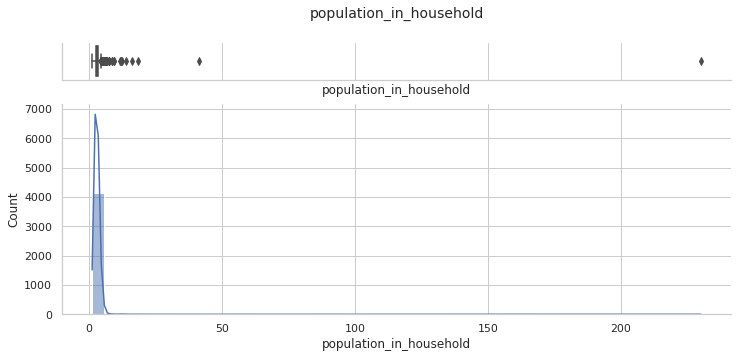


Feature statistics:


,population_in_household
count,4169.000000
mean,3.024084
std,3.682442
min,1.161290
25%,2.435514
50%,2.833071
75%,3.307692
max,230.172414


-----------------------------------------------------------------------------------------------
Feature: bedroom_index


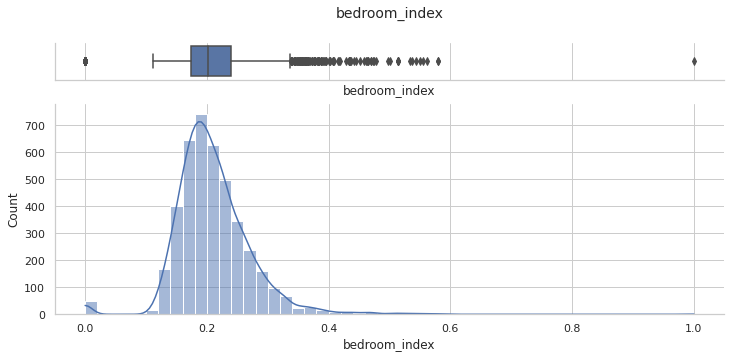


Feature statistics:


,bedroom_index
count,4169.000000
mean,0.210380
std,0.061868
min,0.000000
25%,0.173453
50%,0.201796
75%,0.239130
max,1.000000


In [11]:
create_visualization(
    data=data.sample(True, 0.2, RANDOM_STATE).toPandas(),
    dtype='quantitative',
    target='median_house_value')

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'><s>При использовании .toPandas() ты выгружаешь данные в оперативную память, что при работе с действительно большими данными приведет к переполнению памяти, этот метод применяется только к агрегированным таблицам(либо к ограниченным подвыборкам). Попробуй реализовать схожий функционал с применением методов pySpark.</s>
</font>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
    
Спасибо за комментарий и ответ на вопрос выше.

Добавил семплирование в 20% от общего колличества.

</div>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>Супер!</font>

#### Анализ категориальных признаков

Visualization of categorical features and target prevalence:

-----------------------------------------------------------------------------------------------
Feature: ocean_proximity


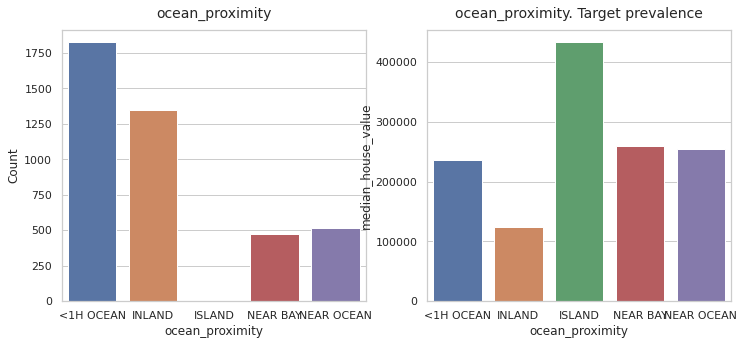

,ocean_proximity,count(ocean_proximity)
0,ISLAND,5
1,NEAR OCEAN,2658
2,NEAR BAY,2290
3,<1H OCEAN,9136
4,INLAND,6551


In [12]:
create_visualization(
    data=data.sample(True, 0.2, RANDOM_STATE).toPandas(),
    dtype='category',
    target='median_house_value')

data.groupBy('ocean_proximity').agg(F.count('ocean_proximity')).toPandas()

#### Анализ целевого признака

Visualization of target distribution:

Target: median_house_value


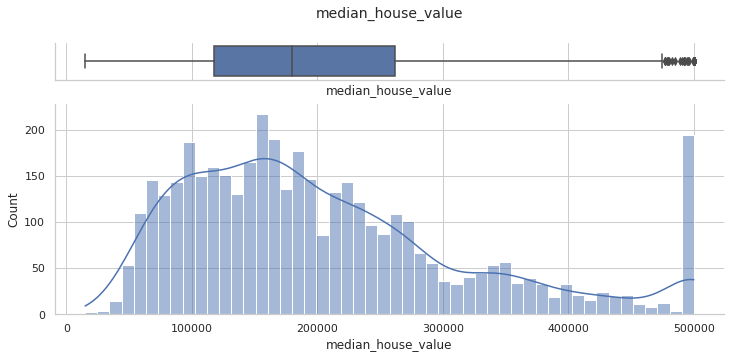


Target statistics:


,median_house_value
count,4169.000000
mean,204850.630127
std,114170.524941
min,14999.000000
25%,118000.000000
50%,179600.000000
75%,261500.000000
max,500001.000000


In [13]:
create_visualization(
    data=data.sample(True, 0.2, RANDOM_STATE).toPandas(),
    dtype='target',
    target='median_house_value',
    target_type='regression')

Исходя из анализа данных можно сделать следующие выводы:
- Данные распределены ненормально и в них присутствуют выбросы, что обуславливает необходимость стандартизации данных;
- Параметр `ocean_proximity` содержит значение `ISLAND`, которое представлено всего 5 наблюдениями с очень большим среднем значением таргета, вследствие чего из датасета необходимо удалить данные 5 наблюдений.

Удалим из данных 5 наблюдений, в которых значением поля `ocean_proximity` является `ISLAND`.

In [14]:
data = data.filter(data['ocean_proximity'] != 'ISLAND')

print('Number of rows in data after processing:', data.count())

Number of rows in data after processing: 20635


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>👍</font>

### Анализ корреляции между параметрами

#### Корреляция Пирсона

Pearson correlation heatmap:


22/12/24 22:48:59 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/12/24 22:48:59 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS


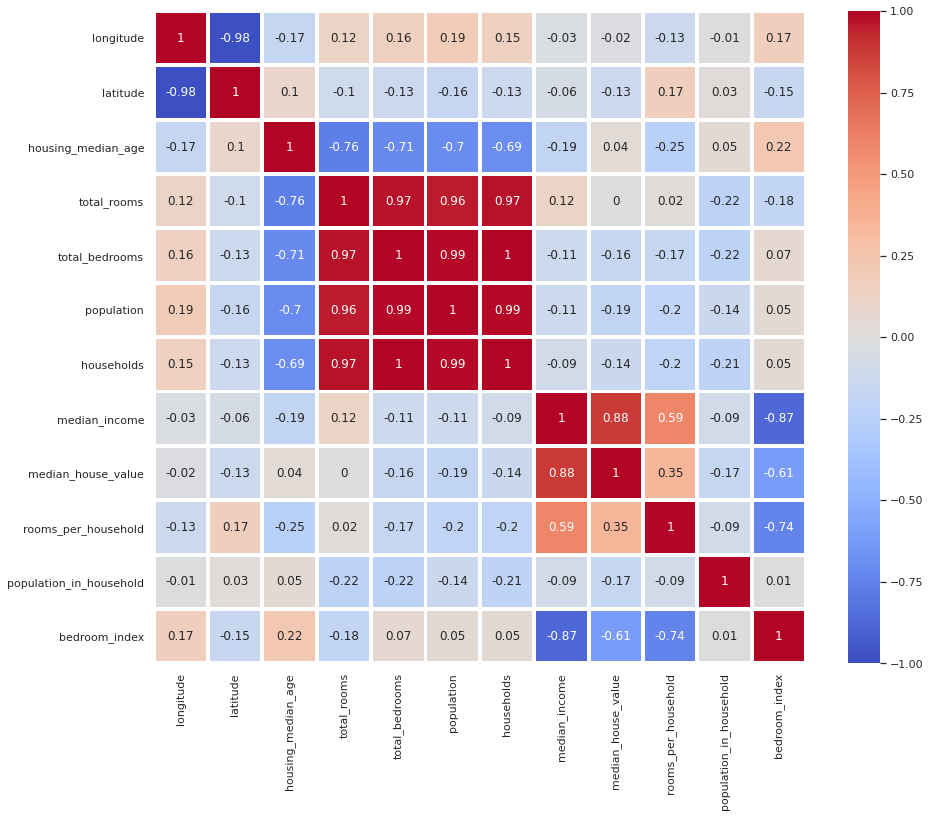

In [15]:
print('Pearson correlation heatmap:')

get_corr_map(data.drop('ocean_proximity'))

#### Корреляция Спирмена

Spearman correlation heatmap:


22/12/24 22:49:09 WARN Executor: Managed memory leak detected; size = 5243098 bytes, TID = 452
22/12/24 22:49:10 WARN Executor: Managed memory leak detected; size = 5243098 bytes, TID = 454


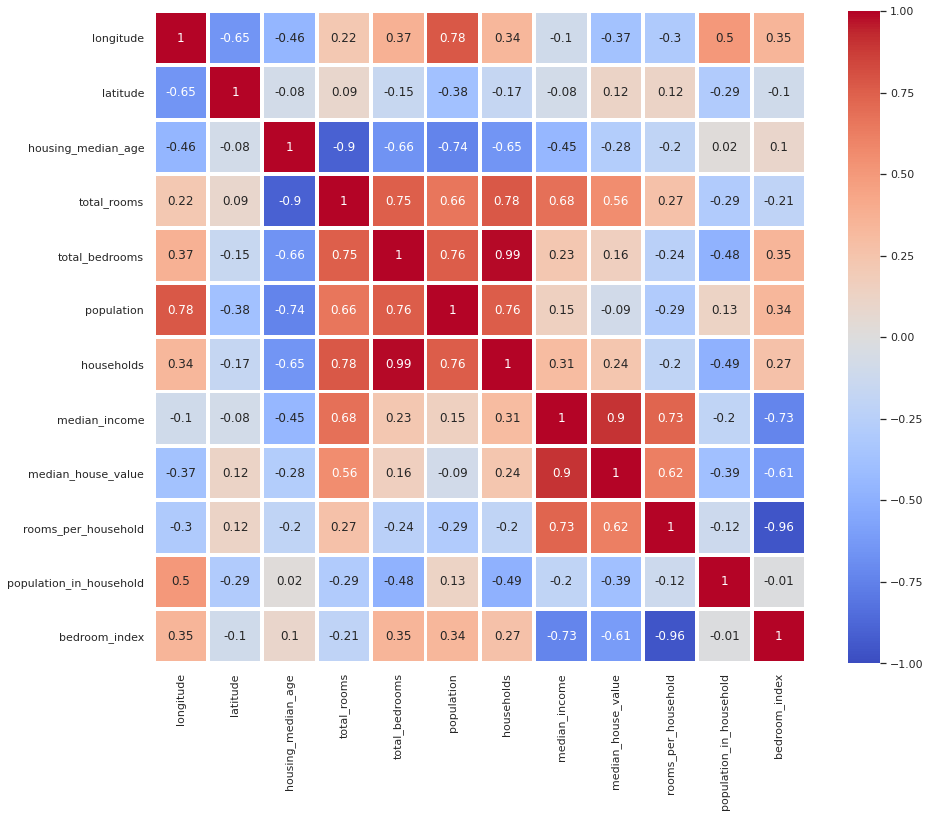

In [16]:
print('Spearman correlation heatmap:')

get_corr_map(data.drop('ocean_proximity'), 'spearman')

Можно сделать вывод, что в данных присутствует частичная мультиколиниарность, что может негативно сказаться на предсказании целевого признака.

In [ ]:

matrix = Correlation.corr(df_corr, 'numerical_features').collect()[0][0] 
corr_matrix = matrix.toArray().tolist() 
corr_matrix_df = pd.DataFrame(data=corr_matrix, columns = matrix_cols, index=matrix_cols) 
corr_matrix_df .style.background_gradient(cmap='coolwarm').set_precision(2)

### Формирование датасета и препроцессинг данных

#### Снижение мультиколиниарности датасета

Удалим наиболее коррелированные признаки из данных.

In [17]:
data = data.drop('total_rooms', 'population', 'total_bedrooms')

print('Data schema after removal of multicollinear features:')

data.printSchema()

Data schema after removal of multicollinear features:
root
 |-- longitude: double (nullable = false)
 |-- latitude: double (nullable = false)
 |-- housing_median_age: double (nullable = false)
 |-- households: double (nullable = false)
 |-- median_income: double (nullable = false)
 |-- median_house_value: double (nullable = false)
 |-- ocean_proximity: string (nullable = true)
 |-- rooms_per_household: double (nullable = true)
 |-- population_in_household: double (nullable = true)
 |-- bedroom_index: double (nullable = true)



Pearson correlation heatmap after removal of multicollinear features:


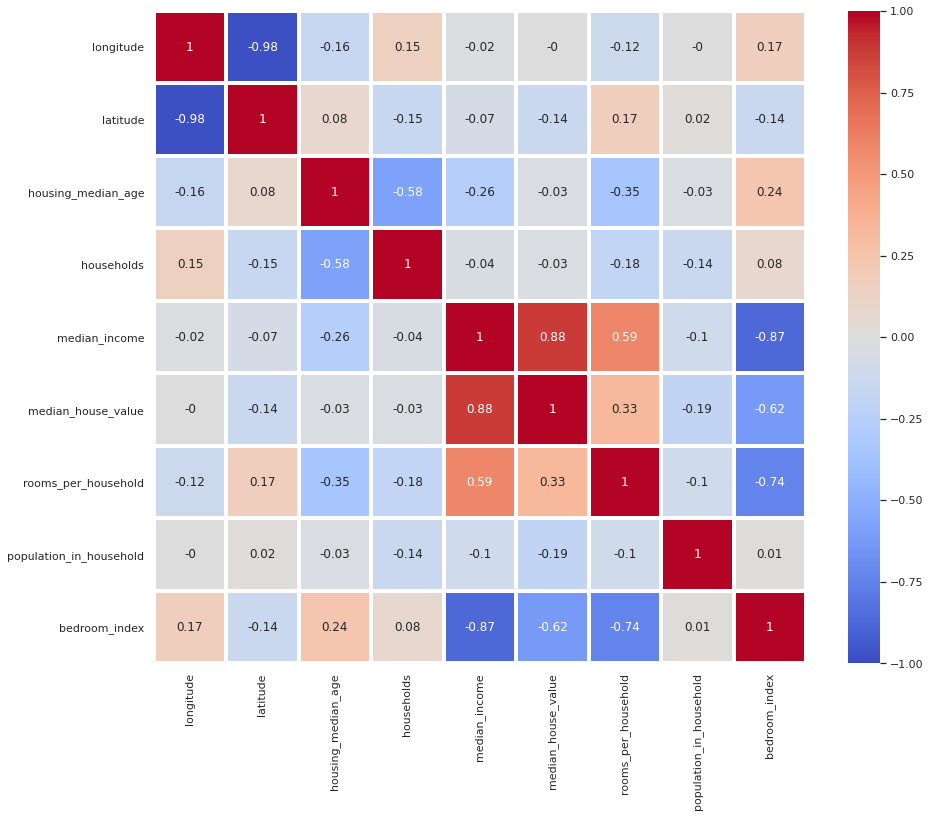

In [18]:
print('Pearson correlation heatmap after removal of multicollinear features:')

get_corr_map(data.drop('ocean_proximity'))

Spearman correlation heatmap after removal of multicollinear features:


22/12/24 22:49:18 WARN Executor: Managed memory leak detected; size = 5244250 bytes, TID = 462
22/12/24 22:49:19 WARN Executor: Managed memory leak detected; size = 5244250 bytes, TID = 464


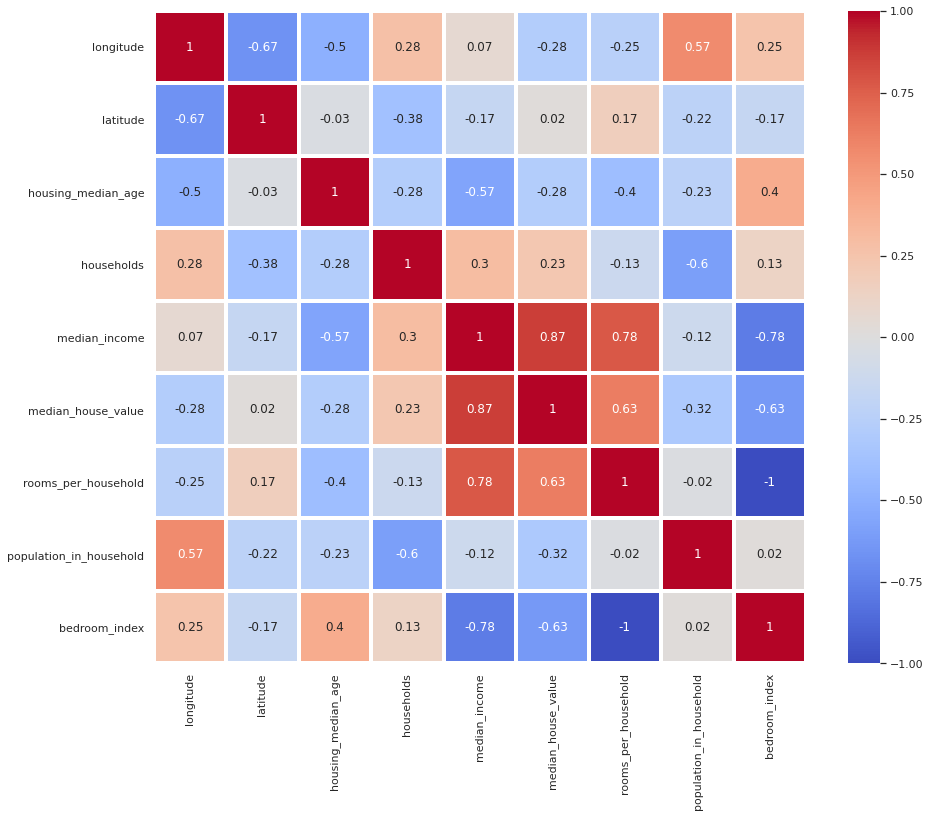

In [19]:
print('Spearman correlation heatmap after removal of multicollinear features:')

get_corr_map(data.drop('ocean_proximity'), 'spearman')

#### Определение независимых переменных и целевого параметра

Определим features и target следующим образом:
- категориальный признак `ocean_proximity` в переменную `cat_features`;
- колличественные признаки - в `num_features`;
- целевой признак - в `target`.

После этого сформируем из данных признаков вектор.

In [20]:
cat_features = ['ocean_proximity']
num_features  = data.drop('ocean_proximity', 'median_house_value').columns
target = 'median_house_value'

features = ['cat_features', 'num_features']

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'><s> В фичах остался таргет.</s></font>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
    
Спасибо за комментарий!
    
Даже стыдно за такую нелепую ошибку... Зато теперь понятно в чем именно был дата лик)

</div>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>👍</font>

In [21]:
num_features

['longitude',
 'latitude',
 'housing_median_age',
 'households',
 'median_income',
 'rooms_per_household',
 'population_in_household',
 'bedroom_index']

### Формирование датасета с колличественными параметрами

In [22]:
num_assembler = VectorAssembler(inputCols=num_features,
                                outputCol='num_features')

ds_num = num_assembler.transform(data) 

In [23]:
final_assembler_num = VectorAssembler(inputCols=[features[1]],
                                      outputCol='features')
ds_num = final_assembler_num.transform(ds_num)

ds_num.select('features').show(5)

+--------------------+
|            features|
+--------------------+
|[-122.23,37.88,41...|
|[-122.22,37.86,21...|
|[-122.24,37.85,52...|
|[-122.25,37.85,52...|
|[-122.25,37.85,52...|
+--------------------+
only showing top 5 rows



#### Формирование обучающей и валидационной выборки для датасета с колличественными параметрами

In [24]:
train_ds_num, val_ds_num = ds_num.randomSplit(TEST_SIZE, seed=RANDOM_STATE)

print('Train dataset with numerical features shape     :', train_ds_num.count())
print('Validation dataset with numerical features shape:', val_ds_num.count())

Train dataset with numerical features shape     : 15498


Validation dataset with numerical features shape: 5137


#### Нормализация колличественных признаков

In [25]:
standardScaler = StandardScaler(inputCol='num_features',
                                outputCol='num_features_scaled')
model = standardScaler.fit(train_ds_num)

train_ds_num = model.transform(train_ds_num)
val_ds_num = model.transform(val_ds_num)

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Зачем нам здесь OHE ?</font>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>

Спасибо за комментарий!
    
Исправил. Вставил его, когда копировал ячейки, а затем забыл убрать.

</div>

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='green'>👍</font>

### Формирование датасета с колличественными и категориальными параметрами

#### Формирование обучающей и валидационной выборки для датаесета с колличественными и категориальными параметрами

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'><s> StringIndexer нужно то же обучить только на Обучающей части данных.</s></font>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>

Спасибо за комментарий!
    
Исправил. Теперь индексирование проводится только на обучающей части данных.

</div>

In [26]:
train_ds_all, val_ds_all = data.randomSplit(TEST_SIZE, seed=RANDOM_STATE)

print('Train dataset with all features shape     :', train_ds_all.count())
print('Validation dataset with all features shape:', val_ds_all.count())

Train dataset with all features shape     : 15498
Validation dataset with all features shape: 5137


In [27]:
indexer = StringIndexer(inputCols=cat_features, 
                        outputCols=[c+'_idx' for c in cat_features])
model = indexer.fit(train_ds_all)

train_ds_all = model.transform(train_ds_all)
val_ds_all = model.transform(val_ds_all)

cat_assembler = \
        VectorAssembler(inputCols=[cat_features[0]+'_idx'],
                        outputCol='cat_features')

train_ds_all = cat_assembler.transform(train_ds_all)
val_ds_all = cat_assembler.transform(val_ds_all)

<font color='blue'><b>Комментарий ревьюера 2: </b></font> ✔️\
<font color='blue'>Такое бывает, что в тестовых данных случается категория которой нет в обучающих. В StringIndexer есть три стратегии обработки незнакомых Лейблов.
1. Выбрасывать исключение (по умолчанию).
2. Игнорировать строки с незнакомыми лейблами.
3. Выделять для всех незнакомых лейблов отдельную категорию.

За это отвечает аргумент [handleInvalid](https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.ml.feature.StringIndexer.html#pyspark.ml.feature.StringIndexer.handleInvalid), в который нужно передать "error","skip" или "keep" соответственно.</font>

In [28]:
num_assembler = VectorAssembler(inputCols=num_features,
                                outputCol='num_features')

train_ds_all = num_assembler.transform(train_ds_all)
val_ds_all = num_assembler.transform(val_ds_all) 

In [29]:
final_assembler_all = VectorAssembler(inputCols=features,
                                      outputCol='features')

train_ds_all = final_assembler_all.transform(train_ds_all)
val_ds_all = final_assembler_all.transform(val_ds_all)

print('Train ds:')
train_ds_all.select('features').show(5)
print()
print('Validation ds:')
val_ds_all.select('features').show(5)

Train ds:
+--------------------+
|            features|
+--------------------+
|[2.0,-124.35,40.5...|
|[2.0,-124.3,41.8,...|
|[2.0,-124.27,40.6...|
|[2.0,-124.26,40.5...|
|[2.0,-124.25,40.2...|
+--------------------+
only showing top 5 rows


Validation ds:
+--------------------+
|            features|
+--------------------+
|[2.0,-124.3,41.84...|
|[2.0,-124.23,40.5...|
|[2.0,-124.23,41.7...|
|[2.0,-124.22,41.7...|
|[2.0,-124.19,40.7...|
+--------------------+
only showing top 5 rows



#### OHE для категориального признака

In [30]:
encoder = OneHotEncoder(inputCols=[cat_features[0] + '_idx'],
                        outputCols=[cat_features[0] + '_ohe'])
model = encoder.fit(train_ds_all)

train_ds_all = model.transform(train_ds_all)
val_ds_all = model.transform(val_ds_all)

#### Нормализация колличественных признаков

In [31]:
standardScaler = StandardScaler(inputCol='num_features',
                                outputCol='num_features_scaled')
model = standardScaler.fit(train_ds_all)

train_ds_all = model.transform(train_ds_all)
val_ds_all = model.transform(val_ds_all)

## Обучение моделей

В качестве модели возьмем модель линейной регрессии.

In [32]:
lr = LinearRegression(maxIter=100, regParam=0.3, elasticNetParam=0.8, standardization=False,
                      labelCol=target, featuresCol='features')

### Модель для датасета с колличественными и категориальным признаками

In [33]:
model_all = lr.fit(train_ds_all)

print('Model is fitted')
print()

print('Coefficients: %s' % str(model_all.coefficients))
print()
print('Intercept: %s' % str(model_all.intercept))
print()

trainingSummary = model_all.summary
print('numIterations: %d' % trainingSummary.totalIterations)
print('objectiveHistory: %s' % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print('RMSE: %f' % trainingSummary.rootMeanSquaredError)
print('r2: %f' % trainingSummary.r2)

Model is fitted

Coefficients: [762.0986705087688,-41784.85239325667,-40380.875545527284,1236.8197844603967,26.130689527694503,42128.143259853816,3194.53935455915,-407.89259540180376,273766.8369837736]

Intercept: -3637211.898679738

numIterations: 29
objectiveHistory: [0.5000000000000002, 0.4266510716631416, 0.29176320657887095, 0.2404432554874201, 0.22225560710077527, 0.20964954552599793, 0.2070629812027238, 0.2000398578340682, 0.19912797329902832, 0.1939087300495549, 0.19084852423652324, 0.1907053065181199, 0.19055876984818534, 0.19022084826792876, 0.19021482996344422, 0.19021216597416674, 0.1902110174880549, 0.1902108246894854, 0.19021081342090213, 0.19021080590089934, 0.19021080522297673, 0.19021080489510325, 0.1902108048844228, 0.19021080488245687, 0.19021080488214992, 0.19021080488188913, 0.19021080488178038, 0.19021080488176925, 0.1902108048816683]
+------------------+
|         residuals|
+------------------+
|-92433.95593982702|
| 22853.67727139825|
|-74195.37931778748|
|-465

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>👍</font>

### Модель для датасета с колличественными признаками

In [34]:
model_num = lr.fit(train_ds_num)

print('Model is fitted')
print()

print('Coefficients: %s' % str(model_num.coefficients))
print()
print('Intercept: %s' % str(model_num.intercept))
print()

trainingSummary = model_num.summary
print('numIterations: %d' % trainingSummary.totalIterations)
print('objectiveHistory: %s' % str(trainingSummary.objectiveHistory))
trainingSummary.residuals.show(5)
print('RMSE: %f' % trainingSummary.rootMeanSquaredError)
print('r2: %f' % trainingSummary.r2)

Model is fitted

Coefficients: [-41993.53335429005,-40427.637829663196,1242.6708159792688,26.194983027578093,42098.560683290976,3208.0114109601645,-408.9461588083508,273392.0019605019]

Intercept: -3659878.8958976166

numIterations: 23
objectiveHistory: [0.5000000000000002, 0.4267189307436768, 0.2925939957551574, 0.2410088288740335, 0.2225676089253778, 0.2098053529995225, 0.2051430748850336, 0.19963128172170838, 0.19851455319035627, 0.19291711093984226, 0.19219523724460272, 0.19033594356324032, 0.19024320976852882, 0.19022943246377097, 0.19022868446019192, 0.19022832275660667, 0.19022831446782545, 0.19022831346201632, 0.19022831344503355, 0.1902283134195217, 0.19022831341728874, 0.1902283134171872, 0.1902283134171046]
+------------------+
|         residuals|
+------------------+
| -92554.8067416721|
|22982.143263601698|
|-74181.35431777732|
|-46654.90696248505|
|-83387.59019421088|
+------------------+
only showing top 5 rows

RMSE: 70961.723287
r2: 0.619561


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>👍</font>

## Анализ результатов

### Результаты модели с колличественными и категориальным признаками

In [35]:
pred_all = model_all.transform(val_ds_all)

print('Predictions:')
pred_all.select(target, 'prediction').show() 

Predictions:
+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|101222.73344432889|
|          106700.0|188403.44426085008|
|           73200.0| 73271.85625774972|
|           78300.0| 70664.16210233793|
|           90100.0|177476.19785743393|
|           67000.0|125200.52215943113|
|           86400.0|151669.26690427586|
|           70500.0|125865.80617872486|
|           60000.0|155081.54808155308|
|           75500.0|130289.33934570011|
|          109400.0| 121086.8622826687|
|           85100.0|144187.45079028746|
|           92700.0|144491.09781287238|
|           80500.0|139653.74880230334|
|           96000.0| 131807.2529977667|
|           75500.0| 101686.8337811036|
|           75000.0| 51126.61249078624|
|          100600.0| 156897.0688295709|
|           74100.0|120222.09543548198|
|           66800.0|  95075.1075331592|
+------------------+------------------+
only showing top 20 rows



In [36]:
rmse_all = RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(pred_all)
mae_all = RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(pred_all)
r2_all = RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(pred_all)

print('RMSE:', round(rmse_all, 2))
print('MAE: ', round(mae_all, 2))
print('R2:  ', round(r2_all, 2))

RMSE: 72964.03
MAE:  53444.49
R2:   0.61


### Результаты модели с колличественными признаками

In [37]:
pred_num = model_num.transform(val_ds_num)

print('Predictions:')
pred_num.select(target, 'prediction').show() 

Predictions:
+------------------+------------------+
|median_house_value|        prediction|
+------------------+------------------+
|          103600.0|101055.02421533456|
|          106700.0|188499.64637894742|
|           73200.0| 73087.35237577418|
|           78300.0| 70571.57326059509|
|           90100.0|177383.46850359114|
|           67000.0|125150.55735283624|
|           86400.0|151612.15193524025|
|           70500.0|125886.16997973109|
|           60000.0|155041.60644201376|
|           75500.0| 130341.7224766356|
|          109400.0|120879.36651864648|
|           85100.0|144160.40220376663|
|           92700.0|144558.88406661572|
|           80500.0| 139713.2447820399|
|           96000.0| 131644.1143800267|
|           75500.0|101551.23842930002|
|           75000.0| 50954.68199371919|
|          100600.0|156786.41287119733|
|           74100.0| 120248.8724735463|
|           66800.0| 94963.81201458909|
+------------------+------------------+
only showing top 20 rows



In [38]:
rmse_num = RegressionEvaluator(labelCol='median_house_value', metricName='rmse').evaluate(pred_num)
mae_num = RegressionEvaluator(labelCol='median_house_value', metricName='mae').evaluate(pred_num)
r2_num = RegressionEvaluator(labelCol='median_house_value', metricName='r2').evaluate(pred_num)

print('RMSE:', round(rmse_num, 2))
print('MAE: ', round(mae_num, 2))
print('R2:  ', round(r2_num, 2))

RMSE: 72963.71
MAE:  53446.14
R2:   0.61


<font color='blue'><b>Комментарий ревьюера :</b></font> ✔️\
<font color='green'>Тестирование проведено верно.</font>

### Сведение результатов в общую таблицу

In [39]:
res = pd.DataFrame(
    {
        'RMSE': [rmse_all, rmse_num],
        'MAE':  [mae_all, mae_num],
        'R2':   [r2_all, r2_num],
    }, index=['Num and cat features', 'Only num features']
).T

res = round(res, 2)

## Завершение Spark-сессии

In [40]:
spark.stop()

print('Spark session has been stopped')

Spark session has been stopped


<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Верно, что не забываешь закрвать сессию.</font>

## Вывод

В данной работе были разработы две ML-модель линейной регрессии для опредения медианной цены дома в жилом массиве:
- Модель с комбинацией колличественных и категориальных параметров;
- Модель только с колличественными параметрами.

Результ работа обеих моделей представлены в таблице ниже.

In [41]:
res

,Num and cat features,Only num features
RMSE,72964.03,72963.71
MAE,53444.49,53446.14
R2,0.61,0.61


Можно сделать вывод, что обе модели имеют приблизительно одинаковый результат, со средней абсолютной ошибкой на уровне 53445 долларов, что говорит о средней предсказательной способности моделей. Тем не менее, модели функционируют значительно лучше, чем использование просто среднего значения целевого показателя, о чем гооворит значение R2, равное 0.61.

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Очень приятно видеть вывод в конце проекта!\
Приведены ответы на главные вопросы проекта.</font>

<div class="alert alert-block alert-info">
<b>Комментарий студента:</b>
    
Привет! Спасибо за ревью моего проекта!

Почти уверен, что где-то допустил серьезную утечку данных, или неправильно настроил гиперпараметры (вроде, брал дефолтные), так как точность модели запредельная.
    
Поскольку уже не укладываюсь в сроки, надеюсь ты сможешь подсказать как так получилось.
    
С нетерпением жду ревью.
    
Спасибо!
    
![](https://c.tenor.com/woog9FdsHDYAAAAC/duck-dance.gif)
</div>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'> Хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
</font>

<font color='blue'>Что нужно исправить:</font>
<ul><font color='red'>Поправь работу с данными(toPandas только для агрегированных данных).</font></ul>
<ul><font color='red'>StringIndexer нужно обучить только на train.</font></ul>
<ul><font color='red'>Убери таргет из фич )).</font></ul>

<font color='blue'>Что можно сделать лучше:</font>
<font color='orange'>В работе я оставил несколько советов. Буду рад, если ты учтешь их.</font></ul>

<font color='blue'><b>Жду новую версию проекта :)</b></font>

<font color='blue'><b>Итоговый комментарий ревьюера 2</b></font>\
<font color='green'> Проект принят! \
Все этапы пройдены. Все рекомендации учтены.\
Надеюсь, тебе понравился процесс выполнения и результат.</font> \
<font color='blue'><b>Спасибо, удачи в освоении профессии!</b></font>

<font color='green'>Немного полезного материала:
+  https://www.tutorialspoint.com/pyspark/index.htm
+  https://www.guru99.com/pyspark-tutorial.html
+  https://databricks.com/spark/getting-started-with-apache-spark/machine-learning#load-sample-data
</font>